In [1]:
# ------------------  set up logging ----------------------
import logging
from auditory_cortex.utils import set_up_logging
set_up_logging('info')

import os
import scipy
from statsmodels.stats.multitest import multipletests
import numpy as np

from matplotlib.lines import Line2D

from auditory_cortex import utils
from auditory_cortex.analyses import Correlations, STRFCorrelations

from auditory_cortex.plotters.correlation_plotter import RegPlotter
from auditory_cortex import results_dir
from auditory_cortex.plotters.plotter_utils import PlotterUtils

from auditory_cortex.plotters import tikzplots

import matplotlib.pylab as plt
import matplotlib as mpl
%matplotlib inline


    If you do not have SoX, proceed here:
     - - - http://sox.sourceforge.net/ - - -

    If you do (or think that you should) have SoX, double-check your
    path variables.
    


/bin/sh: line 1: sox: command not found
/home/ahmedb/projects/Wav2Letter/deepspeech.pytorch/deepspeech_pytorch/loader/data_loader.py:17: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")


In [2]:
threshold = 0.5
save_tikz=True
lag=200



### using multiple-layers for prediction

In [12]:
middle_layers = False
area = 'all'
bin_width = 50
normalized = True
model_name = 'whisper_tiny'
# identifier = 'timit_trf_lags300_bw50_naplib_matched'
identifier = 'ucsf_timit_trf_lags200_bw50_regression_improved'

mVocs = True if 'mVocs' in identifier else False
corr_obj = Correlations(model_name+'_' + identifier)
all_layer_dists = corr_obj.get_corr_all_layers_for_bin_width(
        neural_area=area, bin_width=bin_width,
        threshold=threshold, normalized=normalized,
        mVocs=mVocs,
    )
if middle_layers:
    identifier = 'ucsf_timit_trf_lags200_bw50_regression_improved_middle_layers'
else:
    identifier = 'ucsf_timit_trf_lags200_bw50_regression_improved_all_layers'

mVocs = True if 'mVocs' in identifier else False
corr_obj = Correlations(model_name+'_' + identifier)
all_dists = corr_obj.get_corr_all_layers_for_bin_width(
        neural_area=area, bin_width=bin_width,
        threshold=threshold, normalized=normalized,
        mVocs=mVocs,
    )
combined_dist = all_dists[0]

INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...


INFO:Peak corr (median): 0.5924593921399006, occurs at x_coordinate: 2
INFO:Peak corr (max): 0.9298824673090876, occurs at x_coordinate: 2
INFO:Peak corr (median): 0.5963481281728162, occurs at x_coordinate: 0
INFO:Peak corr (max): 0.9283325901424864, occurs at x_coordinate: 0


Layer 0, p-value: 0.0000, statistic: 75974.0000
Layer 1, p-value: 0.0000, statistic: 50685.0000
Layer 2, p-value: 0.0000, statistic: 53187.0000
Layer 3, p-value: 0.0000, statistic: 73922.0000
Layer 4, p-value: 0.0000, statistic: 78486.0000
Layer 5, p-value: 0.0000, statistic: 80637.0000
Applying multiple correction to p-values, using holm method.
result saved at: /depot/jgmakin/data/auditory_cortex/results/tikz_plots/decode-using-all-layers.tex


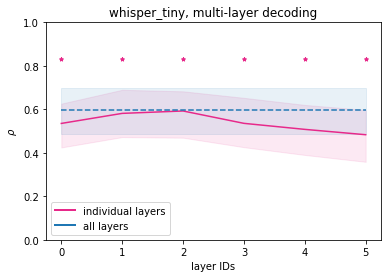

In [20]:
multicorrect = True
correction_method = 'holm'
# correction_method = 'bonferroni'
p = 0.01

color = 'black'
offset_y = 0.83
size=15
ax = None
alpha = 0.1
legends = []
display_inter_quartile_range = True
color = PlotterUtils.get_model_specific_color(model_name)
ax=RegPlotter.plot_line_with_shaded_region(
        data_dict=all_layer_dists, color=color, alpha=alpha, ax=ax,
        display_inter_quartile_range=display_inter_quartile_range,
        display_dotted_lines=False,
        )
legends.append(
    Line2D([0], [0], color=color, lw=2, label='individual layers'),
)
baseline_color = 'tab:blue'
middle_dist_all_layers = {key: combined_dist for key in all_layer_dists.keys()}
RegPlotter.plot_line_with_shaded_region(
    data_dict=middle_dist_all_layers,
    color=baseline_color, alpha=alpha, ax = ax,
    display_dotted_lines=False,
    display_inter_quartile_range=display_inter_quartile_range,
    median_ls='--'
    )
legends.append(
    Line2D([0], [0], color=baseline_color, lw=2, label='layers 1-3' if middle_layers else 'all layers'),
)

p_values = []
for layer_id, dist in all_layer_dists.items():
    stat_result = scipy.stats.wilcoxon(
        x = combined_dist, 
        y = dist,
        alternative='greater', # tests only for x greater than y, (default was "two-sided")
    )
    p_values.append(stat_result.pvalue)
    print(f"Layer {layer_id}, p-value: {stat_result.pvalue:.4f}, statistic: {stat_result.statistic:.4f}")

if multicorrect:
    print(f"Applying multiple correction to p-values, using {correction_method} method.")
    _, p_values, _, _ = multipletests(p_values, alpha=p, method=correction_method)

p_values = np.array(p_values)
sig_indices = np.where(p_values < p)[0]
heights = np.ones(len(sig_indices))*offset_y
ax.scatter(sig_indices, heights, color=color, marker='*', s=size)
        


plt.ylabel(f"$\\rho$")
plt.title(f"{model_name}, multi-layer decoding")
plt.xlabel(f"layer IDs")
ax.legend(handles=legends, loc='best')
ax.set_ylim(0.0, 1.0)


filename = f"decode-using-middle-layers.tex" if middle_layers else f"decode-using-all-layers.tex"
if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        filename,
        )
    PlotterUtils.save_tikz(filepath)

INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...


(array([ 18., 205., 160.,  16.,   2.,   0.,   0.,   0.,   0.,   3.]),
 array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
 <BarContainer object of 10 artists>)

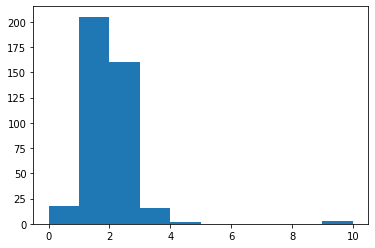

In [5]:
model_name = 'whisper_tiny'
threshold = 0.5
identifier = 'ucsf_timit_trf_lags200_bw50_regression_improved_all_layers'
mVocs = True if 'mVocs' in identifier else False
corr_obj = Correlations(model_name+'_' + identifier)

data = corr_obj.get_highly_tuned_channels(
    corr_obj.data, threshold=threshold, mVocs=mVocs
    )
plt.hist(data['opt_lmbda'])

In [6]:
np.logspace(-5, 10, 16)

array([1.e-05, 1.e-04, 1.e-03, 1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02,
       1.e+03, 1.e+04, 1.e+05, 1.e+06, 1.e+07, 1.e+08, 1.e+09, 1.e+10])

### linear projections

Identifier: ucsf_timit_trf_lags200_bw50_regression_improved
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Peak corr (median): 0.5924593921399006, occurs at x_coordinate: 2
INFO:Peak corr (max): 0.9298824673090876, occurs at x_coordinate: 2
Identifier: ucsf_reset_timit_trf_lags200_bw50_regression_improved
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Peak corr (median): 0.5649088303558862, occurs at x_coordinate: 1
INFO:Peak corr (max): 0.8780196615200477, occurs at x_coordinate: 2
Identifier: ucsf_timit_trf_lags200_bw50_regression_improved_random_linear
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Peak corr (median): 0.53024457436385, occurs at x_coordinate: 1
INFO:Peak corr (max): 0.8714135518674727, occurs at x_coordinate: 1
Identifier: ucsf_timit_trf_lags200_bw50_regressio

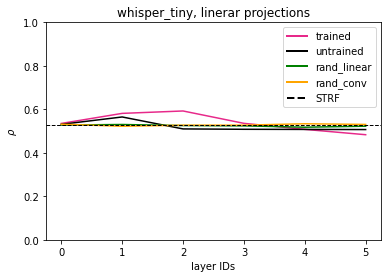

In [4]:
model_name = 'whisper_tiny'
identifiers = {
    'trained': f'ucsf_timit_trf_lags{lag}_bw50_regression_improved',
    'untrained': f'ucsf_reset_timit_trf_lags{lag}_bw50_regression_improved',
    'rand_linear': f'ucsf_timit_trf_lags{lag}_bw50_regression_improved_random_linear',
    'rand_conv': f'ucsf_timit_trf_lags{lag}_bw50_regression_improved_random_conv',
    # 'rand_linear': 'ucsf_timit_trf_lags300_bw50_random_proj',
    # 'rand_conv': f'ucsf_timit_trf_lags300_bw50_random_conv',
}
baseline_identifier = f"mel_wh_ucsf_timit_trf_lags{lag}_bw50_regression_improved"
baseline_identifier = 'STRF_freqs80_'+baseline_identifier

blues = ['#00008B', '#003366', '#4682B4', '#87CEEB', '#ADD8E6']
whisper_color = PlotterUtils.get_model_specific_color(model_name)
colors = {
    'trained': whisper_color, 'untrained': 'black',
    'rand_linear': 'green', 'rand_conv': 'orange',
    'rand_conv_gelu': 'purple', 
    'reset_1': blues[1], 'reset_2': blues[2], 'reset_3': blues[3], 
    'wh_layer_4': 'red'
}
area = 'all'
bin_width = 50
delay = 0
mVocs = False
normalized=True
ax = None
alpha = 0.1
legends = []
display_inter_quartile_range = False
for idx, (label, iden) in enumerate(identifiers.items()):
    print(f"Identifier: {iden}")
    color = colors[label]
    corr_obj = Correlations(model_name+'_'+iden)
    data_dist = corr_obj.get_corr_all_layers_for_bin_width(
                    neural_area=area, bin_width=bin_width, delay=delay,
                    threshold=threshold, normalized=normalized,
                    mVocs=mVocs, 
                )
    # plotting individual distributions...
    ax=RegPlotter.plot_line_with_shaded_region(
        data_dict=data_dist, color=color, alpha=alpha, ax=ax,
        display_inter_quartile_range=display_inter_quartile_range,
        display_dotted_lines=False,
        )

    legends.append(
        Line2D([0], [0], color=color, lw=2, label=label,),
    )

color = 'black'
strf_obj = STRFCorrelations(baseline_identifier)
baseline_dist = strf_obj.get_correlations_for_bin_width(
    neural_area=area, bin_width=bin_width, delay=delay,
    threshold=threshold, normalized=normalized, mVocs=mVocs,
    lag=None,   # saying lag=0.3
)
plt.axhline(np.median(baseline_dist), color=color, lw=1, ls='--')
label = 'STRF'
print(f"{label}: {np.median(baseline_dist)}")
legends.append(
        Line2D([0], [0], color=color, lw=2, label=label, ls='--'),
    )
plt.ylabel(f"$\\rho$")
plt.title(f"{model_name}, linerar projections")
plt.xlabel(f"layer IDs")
ax.legend(handles=legends, loc='best')
ax.set_ylim(0.0, 1.0)

if save_tikz:
    filepath = os.path.join(
        results_dir,
        'tikz_plots',
        f"linear-projections.tex"
        )
    PlotterUtils.save_tikz(filepath)

### Layer-wise plots for TRF=100ms

In [3]:

lag = 50
multicorrect=True
correction_method='fdr_bh' #'fdr_bh' #

y_lims = [0.18, 0.85]
sig_offset_y=0.80
arch_ind_offset=0.85

### layerwise...

#### timit

INFO:Plotting trained and shuffled distributions for wav2letter_modified
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Number of channels returned: (404,)
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:Peak corr (median): 0.5656012252152693, occurs at x_coordinate: 3
INFO:Peak corr (max): 0.9464127529538994, occurs at x_coordinate: 0
INFO:Peak corr (median): 0.38137897872641213, occurs at x_coordinate: 0
INFO:Peak corr (max): 0.9999351393504008, occurs at x_coordinate: 0
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
model_name 'baseline' not recognizable!!!
INFO:Peak corr (median): 0.5061299709067171, occurs at x_coordinate: 0
INFO:Peak corr (max): 0.8939255687384563, occurs at x_coordinate: 0
INFO:Applying multiple correction to p-values, using fdr_bh method.
INFO:Trained-untrained: # of significant levels 14..
INFO:Trained

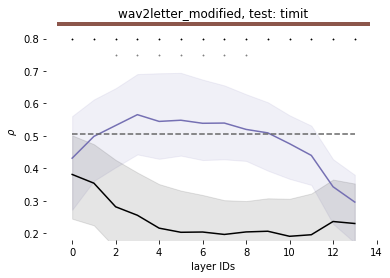

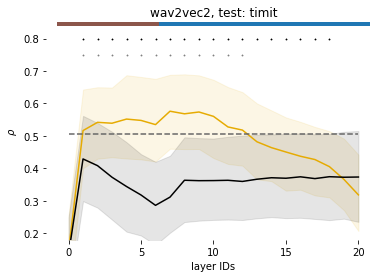

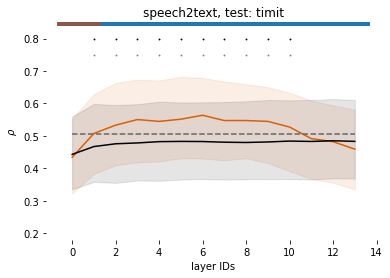

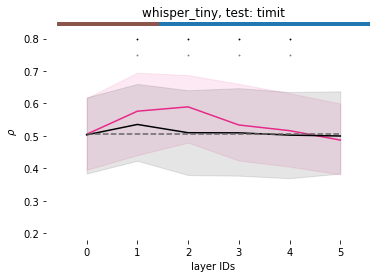

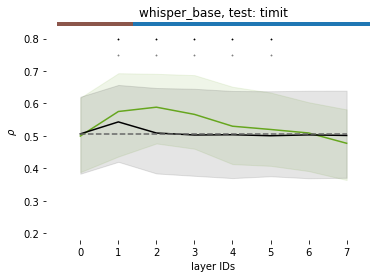

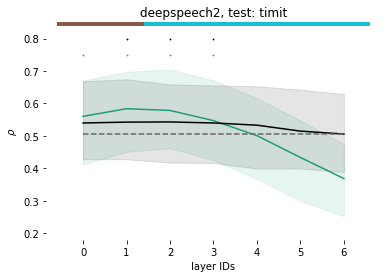

In [4]:
from auditory_cortex.plotters.tikzplots import plot_trained_vs_shuffled_network_results
model_names = [
	'wav2letter_modified',
	'wav2vec2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'deepspeech2',
]
bin_width = 50
trained_identifier = f'ucsf_timit_trf_lags{lag}_bw50_regression_improved'
untrained_identifiers = [trained_identifier.replace('ucsf', 'ucsf_reset')]
tikz_indicator = f'trf{lag}'
baseline_identifier = f"coch_ucsf_timit_trf_lags{lag}_bw50_regression_improved"
baseline_identifier = 'STRF_freqs80_'+baseline_identifier
if 'mVocs' in trained_identifier:
	mVocs=True
else:
	mVocs=False
normalized=True
plot_trained_vs_shuffled_network_results(
		model_names=model_names,
		normalized=normalized,
		threshold=threshold,
		untrained_identifiers = untrained_identifiers,
		trained_identifier = trained_identifier,
		# areas = ['core', 'belt', 'parabelt'],
		baseline_identifier=baseline_identifier,
		indicate_significance=True,
		plot_normalized=False,
		display_dotted_lines=False,
		mVocs=mVocs,
		save_tikz=save_tikz,
		arch_ind_lw=8,
		sig_ind_size=1,
        sig_offset_y=sig_offset_y,
        arch_ind_offset=arch_ind_offset,
        y_lims=y_lims,
		tikz_indicator=tikz_indicator,
		bin_width=bin_width,
		plot_baseline=True,
		use_stat_inclusion=False,
        multicorrect=multicorrect,
        correction_method=correction_method,
)
# model_name = model_names[0]
# plt.savefig(f"layerwise_{model_name}.svg", dpi=300, bbox_inches='tight')

#### mVocs

INFO:Plotting trained and shuffled distributions for wav2letter_modified
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:Number of channels returned: (489,)
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:Peak corr (median): 0.6840778966636638, occurs at x_coordinate: 6
INFO:Peak corr (max): 1.1250448406877556, occurs at x_coordinate: 5
INFO:Peak corr (median): 0.435596621515992, occurs at x_coordinate: 0
INFO:Peak corr (max): 0.9104777708360464, occurs at x_coordinate: 13
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
model_name 'baseline' not recognizable!!!
INFO:Peak corr (median): 0.5860628277740472, occurs at x_coordinate: 0
INFO:Peak corr (max): 1.116564827815042, occurs at x_coordinate: 0
INFO:Applying multiple correction to p-values, using fdr_bh method.
INFO:Trained-untrained: # of signific

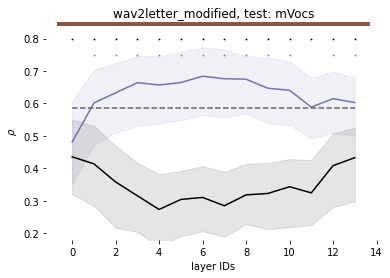

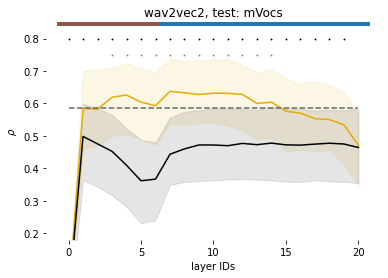

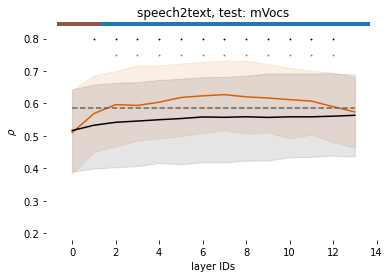

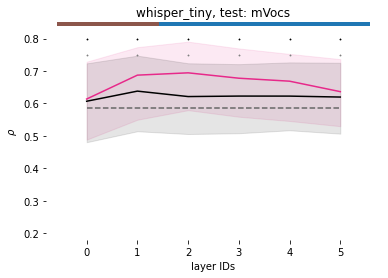

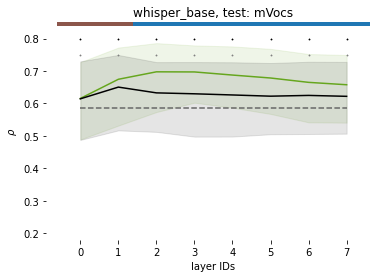

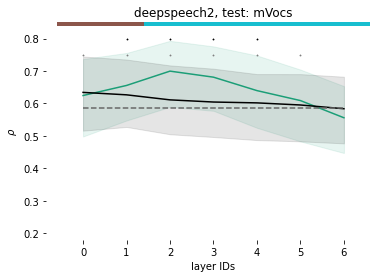

In [5]:
from auditory_cortex.plotters.tikzplots import plot_trained_vs_shuffled_network_results
model_names = [
	'wav2letter_modified',
	'wav2vec2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'deepspeech2',
]
bin_width = 50
trained_identifier = f'ucsf_mVocs_trf_lags{lag}_bw50_regression_improved'
untrained_identifiers = [trained_identifier.replace('ucsf', 'ucsf_reset')]
tikz_indicator = f'trf{lag}'
baseline_identifier = f"coch_ucsf_mVocs_trf_lags{lag}_bw50_regression_improved"
baseline_identifier = 'STRF_freqs80_'+baseline_identifier
if 'mVocs' in trained_identifier:
	mVocs=True
else:
	mVocs=False
normalized=True
plot_trained_vs_shuffled_network_results(
		model_names=model_names,
		normalized=normalized,
		threshold=threshold,
		untrained_identifiers = untrained_identifiers,
		trained_identifier = trained_identifier,
		# areas = ['core', 'belt', 'parabelt'],
		baseline_identifier=baseline_identifier,
		indicate_significance=True,
		plot_normalized=False,
		display_dotted_lines=False,
		mVocs=mVocs,
		save_tikz=save_tikz,
		arch_ind_lw=8,
		sig_ind_size=1,
        sig_offset_y=sig_offset_y,
        arch_ind_offset=arch_ind_offset,
        y_lims=y_lims,
		tikz_indicator=tikz_indicator,
		bin_width=bin_width,
		plot_baseline=True,
		use_stat_inclusion=False,
        multicorrect=multicorrect,
        correction_method=correction_method,
)

### summary - bar plots

#### timit

INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 3
INFO:Number of sig. neurons = 404
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 0
INFO:Number of sig. neurons = 404
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 7
INFO:Number of sig. neurons = 404
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 1
INFO:Number of sig. neurons = 404
INFO:Extracting column: normalized_test_cc
INFO:Filtering 'normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 6
INFO:Number of sig. neurons = 404
INFO:Extra

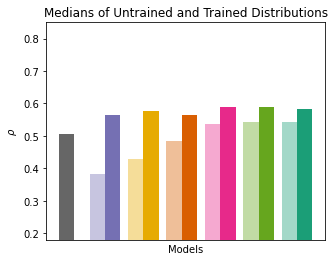

In [7]:
model_names = [
	'wav2letter_modified',
	'wav2vec2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'deepspeech2',
	]
trained_identifier = f'ucsf_timit_trf_lags{lag}_bw50_regression_improved'
untrained_identifiers = trained_identifier.replace('ucsf', 'ucsf_reset')
baseline_identifier = f"coch_ucsf_timit_trf_lags{lag}_bw50_regression_improved"
baseline_identifier = 'STRF_freqs80_'+baseline_identifier
mVocs=False
tikz_indicator = f'trf{lag}'
bin_width = 50
tikzplots.plot_correlations_summary(
	model_names,
	trained_identifier,
    untrained_identifiers,
    baseline_identifier,
    threshold=threshold,
	bin_width=bin_width,
	mVocs=mVocs,
    tikz_indicator=tikz_indicator,
    y_lims=y_lims,
	width = 0.4,
	alpha=0.4,
	save_tikz=save_tikz
	)


#### mVocs

INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 6
INFO:Number of sig. neurons = 489
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 0
INFO:Number of sig. neurons = 489
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 7
INFO:Number of sig. neurons = 489
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with peak median is: 1
INFO:Number of sig. neurons = 489
INFO:Extracting column: mVocs_normalized_test_cc
INFO:Filtering 'mVocs_normalizer' using multiple of 0.500 with std dev ...
INFO:At bin_width: 50, layer with pe

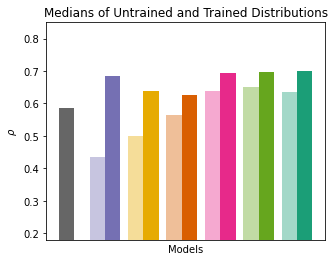

In [8]:
model_names = [
	'wav2letter_modified',
	'wav2vec2',
	'speech2text',
	'whisper_tiny',
	'whisper_base',
	'deepspeech2',
	]
trained_identifier = f'ucsf_mVocs_trf_lags{lag}_bw50_regression_improved'
untrained_identifiers = trained_identifier.replace('ucsf', 'ucsf_reset')
baseline_identifier = f"coch_ucsf_mVocs_trf_lags{lag}_bw50_regression_improved"
baseline_identifier = 'STRF_freqs80_'+baseline_identifier
mVocs=True
tikz_indicator = f'trf{lag}'
bin_width = 50
tikzplots.plot_correlations_summary(
	model_names,
	trained_identifier,
    untrained_identifiers,
    baseline_identifier,
    threshold=threshold,
	bin_width=bin_width,
    tikz_indicator=tikz_indicator,
	mVocs=mVocs,
    y_lims=y_lims,
	width = 0.4,
	alpha=0.4,
	save_tikz=save_tikz
	)
